In [10]:
# 🚀 Auto-setup: installs deps + configures CFBD access
import os
import sys
from pathlib import Path

# Find _auto_setup.py regardless of current working directory
_current = Path().resolve()
_auto_setup_path = None
for parent in [_current] + list(_current.parents):
    candidate = parent / "starter_pack" / "_auto_setup.py"
    if candidate.exists():
        _auto_setup_path = candidate
        # Add project root to sys.path (auto_setup.py will also do this)
        if str(parent) not in sys.path:
            sys.path.insert(0, str(parent))
        break

if _auto_setup_path and _auto_setup_path.exists():
    # Execute the file directly without changing directory
    with open(_auto_setup_path, 'r') as f:
        exec(f.read(), {'__file__': str(_auto_setup_path)})
else:
    # Fallback: try relative path
    try:
        with open("./_auto_setup.py", 'r') as f:
            exec(f.read(), {'__file__': './_auto_setup.py'})
    except FileNotFoundError:
        print("⚠️  Could not find _auto_setup.py. Please run from starter_pack directory.")


🔧 Notebook auto-setup complete:
  • Project root: /Users/stephen_bowman/Documents/GitHub/Script_Ohio_2.0/starter_pack
  • Requirements: /Users/stephen_bowman/Documents/GitHub/Script_Ohio_2.0/starter_pack/requirements.txt
  • Missing modules: none
  • Auto install performed: False


In [11]:
# 09_opponent_adjustments.ipynb
# 📊 Opponent-Adjusted Efficiency Metrics

# 🛠 Requirements: pandas, matplotlib, seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sys
from pathlib import Path

# Import starter pack configuration system
_config_dir = Path().resolve() / "config"
if str(_config_dir.parent) not in sys.path:
    sys.path.insert(0, str(_config_dir.parent))
from config.data_config import get_starter_pack_config

# Get configuration
config = get_starter_pack_config()
current_year = config.current_year
DATA_DIR = str(config.data_dir)

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,8]


In [12]:
# 📂 Load {current_year} advanced game stats and game metadata
# Note: current_year is defined in Cell 1

game_stats = pd.read_csv(str(config.get_data_path(f"advanced_game_stats/{current_year}.csv")))
games = pd.read_csv(os.path.join(DATA_DIR, "games.csv"))

# Filter only FBS games
games = games.query("season == @current_year and home_classification == 'fbs' and away_classification == 'fbs'")
game_stats = games[["id"]].merge(game_stats, how="inner", left_on="id", right_on="gameId")


{"timestamp": "2025-11-25T03:02:28.296234+00:00", "level": "warning", "logger": "py.warnings", "message": "/var/folders/57/ts2cbf317_j7v99p8sk3nwjw0000gn/T/ipykernel_75262/1603760536.py:5: DtypeWarning: Columns (5,6,7,10,19,29,40,61) have mixed types. Specify dtype option on import or set low_memory=False.\n  games = pd.read_csv(os.path.join(DATA_DIR, \"games.csv\"))\n", "service": "script_ohio", "environment": "development", "taskName": "Task-60"}


In [13]:
# 🔗 Join each row with the opponent's per-game average

# Step 1: Compute each team's per-game average strength
df_agg = game_stats.groupby("team").agg({
    "offense_ppa": "mean",
    "defense_ppa": "mean"
}).rename(columns={"offense_ppa": "avg_off_ppa", "defense_ppa": "avg_def_ppa"}).reset_index()

# Step 2: Merge with game logs using the "opponent" column
adjusted = game_stats.merge(df_agg, how="inner", left_on="opponent", right_on="team", suffixes=("", "_opponent"))

In [14]:
# 🧠 Create an adjusted metric: difference between raw and opponent average allowed
adjusted["adj_offense_ppa"] = adjusted["offense_ppa"] - adjusted["avg_def_ppa"]
adjusted["adj_defense_ppa"] = adjusted["defense_ppa"] - adjusted["avg_off_ppa"]

adjusted[["team", "opponent", "offense_ppa", "defense_ppa", "avg_off_ppa", "avg_def_ppa", "adj_offense_ppa", "adj_defense_ppa"]].head(10)

,team,opponent,offense_ppa,defense_ppa,avg_off_ppa,avg_def_ppa,adj_offense_ppa,adj_defense_ppa
0,Iowa State,Kansas State,0.120519,0.114437,0.141452,0.098801,0.021718,-0.027015
1,Kansas State,Iowa State,0.114437,0.120519,0.129312,0.106555,0.007882,-0.008793
2,Fresno State,Kansas,0.062886,0.341493,0.234109,0.236728,-0.173842,0.107383
3,Kansas,Fresno State,0.341493,0.062886,0.063354,0.116479,0.225013,-0.000468
4,Sam Houston,Western Kentucky,0.042159,0.133130,0.171257,0.149256,-0.107097,-0.038127
5,Western Kentucky,Sam Houston,0.133130,0.042159,-0.016158,0.242165,-0.109035,0.058317
6,Hawai'i,Stanford,0.041659,0.076568,0.048980,0.190102,-0.148443,0.027588
7,Stanford,Hawai'i,0.076568,0.041659,0.157451,0.165371,-0.088803,-0.115792
8,Boise State,South Florida,-0.032920,0.319242,0.287588,0.141463,-0.174383,0.031654
9,South Florida,Boise State,0.319242,-0.032920,0.191770,0.099249,0.219993,-0.224690


In [15]:
# 📊 Aggregate adjusted PPA per team

team_adj = adjusted.groupby("team")[["adj_offense_ppa", "adj_defense_ppa"]].mean().reset_index()
team_raw = game_stats.groupby("team")[["offense_ppa", "defense_ppa"]].mean().reset_index()

team_merged = team_raw.merge(team_adj, on="team")
team_merged['raw_diff'] = team_merged['offense_ppa'] - team_merged['defense_ppa']
team_merged['adj_diff'] = team_merged['adj_offense_ppa'] - team_merged['adj_defense_ppa']
team_merged = team_merged.rename(columns={
    "offense_ppa": "Raw Offense EPA",
    "adj_offense_ppa": "Adj Offense EPA",
    "defense_ppa": "Raw Defense EPA",
    "adj_defense_ppa": "Adj Defense EPA",
    "raw_diff": "Raw EPA Diff",
    "adj_diff": "Adj EPA Diff"
}).sort_values("Adj EPA Diff", ascending=False)

team_merged.head(10)

,team,Raw Offense EPA,Raw Defense EPA,Adj Offense EPA,Adj Defense EPA,Raw EPA Diff,Adj EPA Diff
86,Oregon,0.378357,-0.020236,0.198144,-0.129640,0.398593,0.327784
81,Ohio State,0.353179,0.001487,0.185202,-0.141190,0.351692,0.326392
123,Utah,0.326982,0.030493,0.186966,-0.129245,0.296488,0.316210
41,Indiana,0.310000,0.026166,0.178352,-0.128952,0.283834,0.307304
79,Notre Dame,0.302972,0.064122,0.123088,-0.169567,0.238850,0.292655
60,Miami,0.224763,-0.017399,0.076309,-0.197753,0.242162,0.274062
120,USC,0.409869,0.125538,0.236377,-0.036833,0.284332,0.273210
109,Texas Tech,0.238400,-0.051373,0.082369,-0.173084,0.289773,0.255453
2,Alabama,0.272582,0.069261,0.143439,-0.107159,0.203321,0.250598
105,Tennessee,0.332112,0.114000,0.167461,-0.036711,0.218112,0.204172


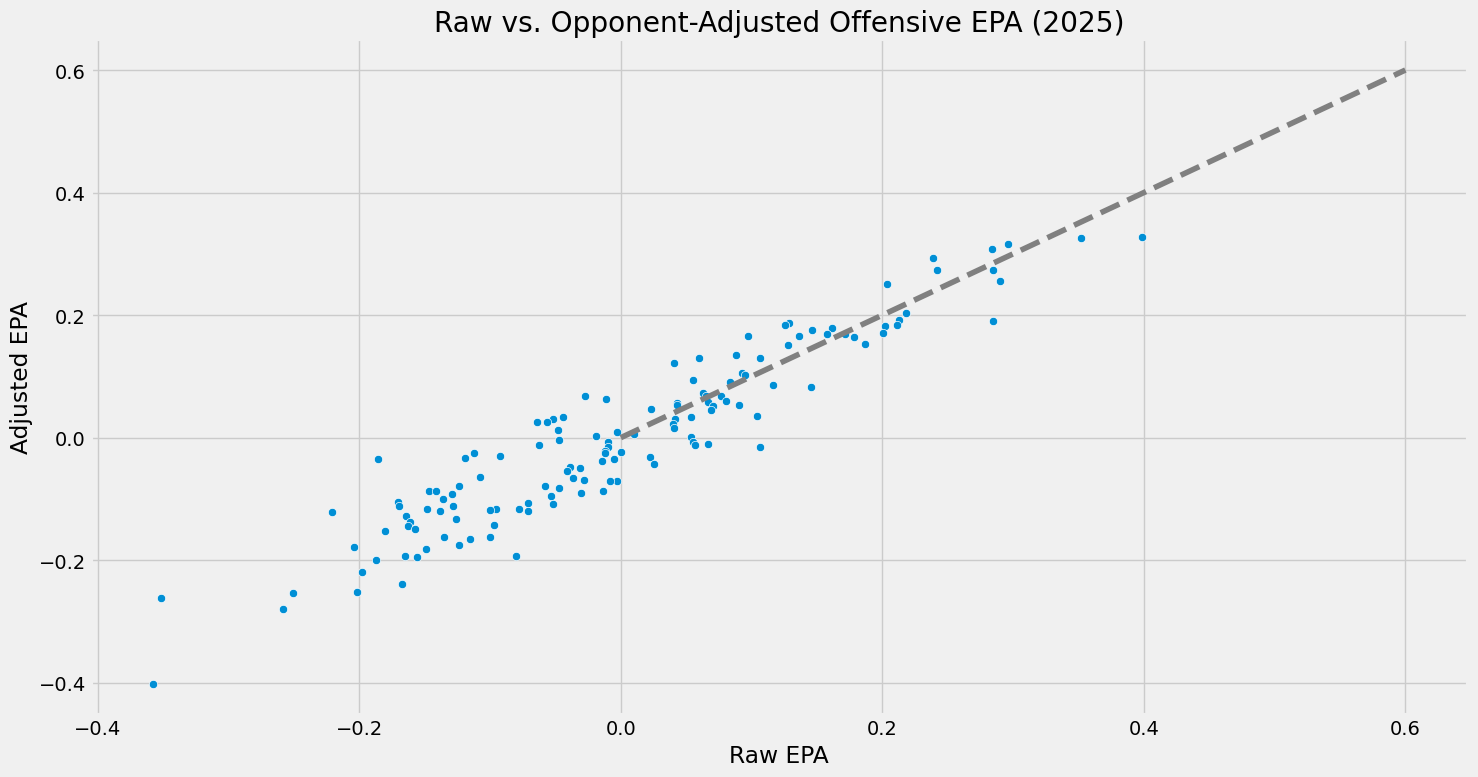

In [16]:
# 📈 Plot raw vs. adjusted EPA

sns.scatterplot(data=team_merged, x="Raw EPA Diff", y="Adj EPA Diff")
plt.title(f"Raw vs. Opponent-Adjusted Offensive EPA ({current_year})")
plt.plot([0, 0.6], [0, 0.6], linestyle="--", color="gray")  # Diagonal line
plt.xlabel("Raw EPA")
plt.ylabel("Adjusted EPA")
plt.tight_layout()
plt.show()

In [17]:
# ✅ Summary

# In this notebook, you:
# - Calculated each opponent’s average defensive EPA allowed
# - Adjusted each team’s offensive EPA for opponent difficulty
# - Aggregated adjusted metrics to create a fairer ranking
# - Compared raw vs. adjusted efficiency

# 🧪 Try This:
# - Do the same for success rate or explosiveness
# - Adjust defensive stats by average opposing offense
# - Create an “opponent-adjusted net rating” = adj_off_epa - adj_def_epa

# 🔗 Bridge to Model Pack

## 🚀 Next Steps: From Opponent Adjustments to 86 ML Features

Great work! You've learned opponent adjustments - the **foundation** of all 86 ML features.

### What You Just Learned → All 86 ML Features

Your opponent adjustment technique is used to create **every single** adjusted feature in model pack:

| Your Adjustment | Model Pack Equivalent | # of Features |
|----------------|----------------------|---------------|
| `adj_offense_ppa` | `home_adjusted_epa` | 1 |
| `adj_defense_ppa` | `home_adjusted_epa_allowed` | 1 |
| Same concept applied to... | All other metrics | 84 more! |

The 86 features include:
- EPA metrics (passing, rushing, total)
- Success rates (standard downs, passing downs, overall)
- Explosiveness (rush, pass, total)
- Line yards, second-level yards, open field yards
- Havoc rates (offense and defense)
- Points per opportunity
- Field position metrics

### Explore the Full Feature Set

See how your technique scales to 86 features:

```python
# Load weekly training data (Week 5+ for temporal validation)
import pandas as pd

# Option 1: Using path utility directly (recommended)
from model_pack.utils.path_utils import get_weekly_training_file
weekly_path = get_weekly_training_file(week=5, season=2025)
weekly = pd.read_csv(weekly_path)

# Option 2: Using config helper (alternative)
# weekly_path = config.get_weekly_training_file(week=5, season=2025)
# weekly = pd.read_csv(weekly_path)

print(f"Week 5: {len(weekly)} games, {len(weekly.columns)} opponent-adjusted features")

# See all adjusted EPA features (using your technique!)
epa_features = [c for c in weekly.columns if 'adjusted_epa' in c]
print(f"\nEPA Features ({len(epa_features)} total):")
print(epa_features)

# See all adjusted success features
success_features = [c for c in weekly.columns if 'adjusted_success' in c]
print(f"\nSuccess Features ({len(success_features)} total):")
print(success_features)

# Sample the data
print("\nSample opponent-adjusted data:")
print(weekly[['home_team', 'away_team', 
              'home_adjusted_epa', 'away_adjusted_epa',
              'home_adjusted_success', 'away_adjusted_success']].head())
```

### Try Model Pack with Your Adjusted Features

1. **XGBoost Model**: `../model_pack/03_xgboost_win_probability.ipynb`
   - Uses ALL 86 opponent-adjusted features you just learned to create
   - Shows which adjusted features are most important
   - Provides win probabilities and feature importance

2. **SHAP Interpretability**: `../model_pack/06_shap_interpretability.ipynb`
   - Understand how each of the 86 adjusted features affects predictions
   - See feature importance rankings
   - Visualize feature contributions

### Why Week 5+ Matters

Model pack uses Week 5+ games only (not Week 1-4). This is **temporal validation**:
- Prevents data leakage (can't use future games to predict past games)
- Ensures opponent adjustments are based on meaningful sample sizes
- Matches real-world prediction scenarios

```python
# See why Week 5+ is important
from model_pack.utils.path_utils import get_weekly_training_file

for week in [1, 5, 10]:
    try:
        weekly_path = get_weekly_training_file(week=week, season=2025)
        weekly = pd.read_csv(weekly_path)
        print(f"Week {week}: {len(weekly)} games available")
    except FileNotFoundError:
        print(f"Week {week}: Not available (model pack uses Week 5+)")
```

### Get Agent Guidance

```python
from agents.analytics_orchestrator import AnalyticsOrchestrator, AnalyticsRequest

orchestrator = AnalyticsOrchestrator()
request = AnalyticsRequest(
    user_id='your_id',
    query='Show me how opponent adjustments create all 86 ML features',
    query_type='learning',
    parameters={'current_notebook': '09_opponent_adjustments.ipynb'},
    context_hints={'role': 'data_scientist'}
)
response = orchestrator.process_analytics_request(request)
print(response.insights)
```

### Your Learning Journey

1. ✅ **You Are Here**: Understanding opponent adjustments (core concept)
2. **Next**: See how this scales to 86 features in weekly training data
3. **Then**: Build ML models using these adjusted features
4. **Finally**: Understand which adjusted features matter most for predictions

---

💡 **Key Insight**: Every feature in model pack training data uses the opponent adjustment
technique you just learned. The difference is scale - you adjusted 2 metrics, model pack
adjusts 86 metrics using the same principle.
